In [15]:
import pickle
import imageio
import torch
import matplotlib.pyplot as plt
import numpy as np
from imgaug import augmenters as iaa
from skimage.transform import rotate, rescale
%matplotlib inline

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [16]:
def shuffle_task_label(labels, task): 
    np.random.seed(1)
    lbl = labels.copy()
    
    for i in task:
        lbl_to_find = range((i-1)*10,i*10)
        
        lbl_ = []
        for j in lbl_to_find:
            indx = list(np.where(labels == j)[0])
            lbl_.extend(indx)
        _lbl = lbl_.copy()
        _lbl = np.asarray(_lbl)
        np.random.shuffle(_lbl)
        _lbl = list(_lbl)
        
        lbl[_lbl] = labels[lbl_]
    return lbl

In [17]:
n_tasks = 10
train_file = './train'
unpickled_train = unpickle(train_file)
train_keys = list(unpickled_train.keys())
fine_labels = np.array(unpickled_train[train_keys[2]])
labels = fine_labels

In [18]:
train_data = np.zeros((len(unpickled_train[b'data']),4,32,32),dtype=int)

for i in range(len(unpickled_train[b'data'])):
    tmp = unpickled_train[b'data'][i].reshape(3,32,32)
    train_data[i,0:3,:,:] = tmp

    
train_data = train_data.reshape(len(unpickled_train[b'data']),64,64)
labels = fine_labels
print(train_data[10,:,:])

[[ 83  67  61 ...  39   9  12]
 [ 73  68  74 ... 105  99  66]
 [ 60  59  70 ...  93 111 109]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [19]:
task_to_suffle = [2,3,4,5,6,7,8,9,10]
labels_ = shuffle_task_label(labels, task_to_suffle)

In [20]:
x = (torch.tensor(train_data),torch.tensor(labels_))
torch.save(x,'datasets/mnist/MNIST/processed/training.pt')

KeyboardInterrupt: 

In [ ]:
shuffle_task_label(np.asarray([0,0,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12]),[1])

In [ ]:
!./main.py --experiment=splitMNIST --tasks=10 --scenario=task --si --c=0.1 --iters=2000 --name 'SI' --tasks_to_complete=10
!./main.py --experiment=splitMNIST --tasks=10 --scenario=task --replay=current --distill --iters=2000 --name 'LwF' --tasks_to_complete=10
!./main.py --experiment=splitMNIST --tasks=10 --scenario=task --ewc --lambda=5000 --iters=2000 --name 'EWC' --tasks_to_complete=10
!./main.py --experiment=splitMNIST --tasks=10 --scenario=task --ewc --online --lambda=5000 --gamma=1 --iters=2000 --name 'Online_EWC' --tasks_to_complete=10

. Perpare train file only for DF-CNN and Prog-NN experiment

In [21]:
unpickled_train[b'fine_labels'] = list(labels_)

In [22]:
with open('train.pickle', 'wb') as f:
    pickle.dump(unpickled_train, f)

In [23]:
unpickled_train[b'data']

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

. code for plotting

In [24]:
import seaborn as sns
%matplotlib inline

In [25]:
def plot_te(te, names):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#000000"]
    c = sns.color_palette(clr, n_colors=len(names))

    for i in range(len(names)):
        ax.plot(np.arange(1,11,1), te[i], label = names[i], c=c[i])

    
    ax.set_title('Shuffled CIFAR', fontsize=20)
    ax.set_xlabel('Number of tasks seen', fontsize=18)
    ax.set_ylabel('Transfer Efficiency', fontsize=18)
    # ax.set_ylim(0.05 - 0.01, 0.5 + 0.01)
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='upper right', fontsize=12)
    #ax.set_yticks([.4,.6,.8,1, 1.2])
    #ax.set_ylim(0.79, 1.21)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax.tick_params(labelsize=14)
    #ax.grid(axis='x')
    plt.tight_layout()
    
    plt.savefig('cifar-100-adv.pdf')

In [26]:
ntasks = 10
filepath = './jd/'
alg = ['EWC', 'Online_EWC', 'SI', 'LwF']
single_task = {'EWC':0.625, 'Online_EWC':0.625, 'SI':0.625, 'LwF':0.625}

In [27]:
te = [[] for i in range(len(alg))]

for i, name in enumerate(alg):
    for task in range(ntasks):
        file_to_load = filepath+name+str(task+1)+'.pickle'
        res = unpickle(file_to_load)
        te[i].append(single_task[name]/res[0])

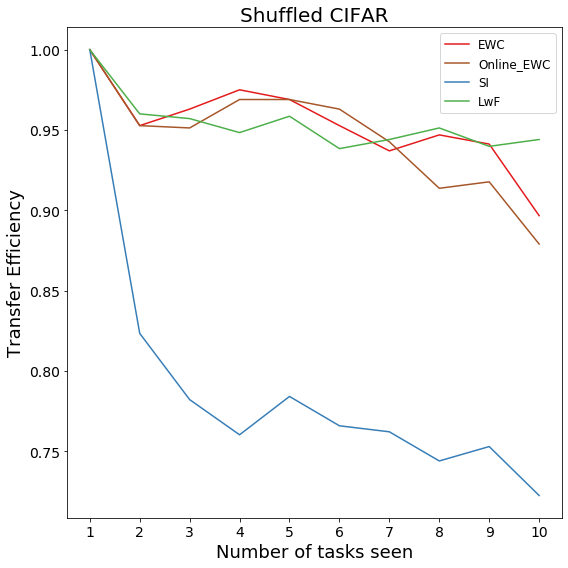

In [28]:
plot_te(te, alg)

In [29]:
err_prog_nn = 0.269/np.asarray([0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269, 0.269])
err_df_cnn = 0.312/np.asarray([0.312, 0.366, 0.472, 0.594, 0.665, 0.694, 0.723, 0.768, 0.8, 0.81])

In [30]:
te.append(list(err_prog_nn))
te.append(list(err_df_cnn))
te.append([1.        , 0.97959834, 0.95013207, 0.930415  , 0.91383664,
        0.90319499, 0.89421549, 0.88775112, 0.88725663, 0.87607937])

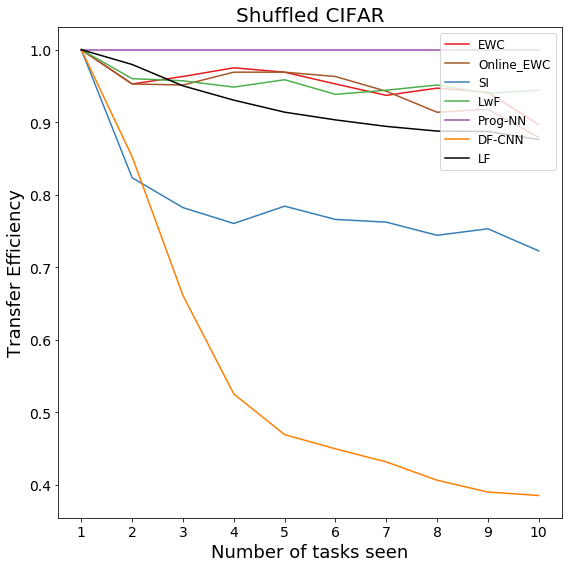

In [31]:
plot_te(te, ['EWC', 'Online_EWC', 'SI', 'LwF', 'Prog-NN', 'DF-CNN', 'LF'])

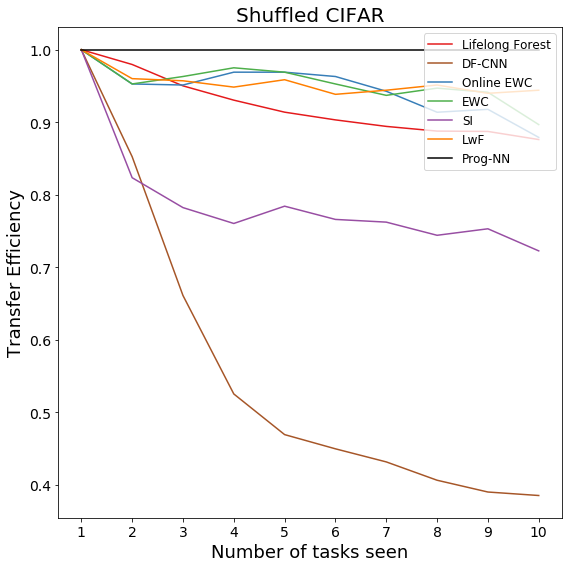

In [32]:
te_ = [te[6], te[5], te[1], te[0], te[2], te[3], te[4]]
names = ['Lifelong Forest', 'DF-CNN', 'Online EWC', 'EWC', 'SI', 'LwF', 'Prog-NN']
plot_te(te_, names)

In [33]:
def calc_rte(err, ntasks):
    task_err = [[err[i][0]/err[i][j] for j in range(0,ntasks-i)] for i in range(0,ntasks)]
    
    return task_err

In [34]:
err_L2F = [[0.616,0.594,0.575,0.547,0.54,0.544,0.526,0.52,0.522,0.519],
           [0.665,0.64,0.636,0.626,0.629,0.616,0.604,0.613,0.614],
           [0.563,0.553,0.548,0.538,0.532,0.53,0.528,0.528],
           [0.608,0.61,0.599,0.599,0.587,0.587,0.591],
           [0.555,0.548,0.549,0.546,0.552,0.546],
           [0.545,0.541,0.541,0.527,0.526],
           [0.53,0.526,0.521,0.52],
           [0.521,0.523,0.514],
           [0.575, 0.573],
           [0.482]]

err_L2F_reduced = [[0.6456, 0.6104, 0.5905, 0.5764, 0.5653, 0.5509, 0.5437, 0.5399, 0.5368, 0.5329],
                   [0.6825, 0.6652, 0.6514, 0.6398, 0.6333, 0.6311, 0.6236, 0.6191, 0.6203],
                   [0.5821, 0.5669, 0.5545, 0.5525, 0.5488, 0.5434, 0.5423, 0.5383],
                   [0.622,  0.6112, 0.6002, 0.5947, 0.5928, 0.5899, 0.587 ],
                   [0.5732, 0.5699, 0.5654, 0.559,  0.5588, 0.5534],
                   [0.5521, 0.5438, 0.5369, 0.5364, 0.5356],
                   [0.5252, 0.519,  0.5171, 0.5146],
                   [0.5399, 0.5326, 0.533 ],
                   [0.5852, 0.5792],
                   [0.4942]]
err_online_ewc = [[0.625,0.642,0.654,0.664,0.662,0.671,0.7,0.714,0.712,0.714], [0.732,0.75,0.761,0.752,0.755,0.772,0.7679,0.773,0.769],
                  [0.584,0.59,0.592,0.586,0.666,0.657,0.672,0.669], [0.656,0.658,0.663,0.696,0.706,0.724,0.731],
                  [0.665,0.681,0.693,0.698,0.703,0.708], [0.644,0.691,0.704,0.707,0.712],
                  [0.617,0.617,0.613,0.626], [0.66,0.663,0.663], [0.695,0.699], [0.635]]

err_ewc = [[0.625,0.642,0.636,0.654,0.643,0.649,0.637,0.648,0.65,0.65], [0.73,0.731,0.728,0.736,0.738,0.73,0.741,0.744,0.748],
           [0.603,0.612,0.615,0.603,0.61,0.611,0.613,0.613], [0.672,0.675,0.676,0.677,0.666,0.667,0.669],
           [0.666,0.678,0.662,0.671,0.671,0.678], [0.649,0.642,0.647,0.652,0.651],
           [0.607,0.616,0.61,0.617], [0.644,0.651,0.641], [0.71, 0.714], [0.652]]

err_SI = [[0.625,0.744,0.755,0.8,0.815,0.815,0.809,0.851,0.81,0.825], [0.725,0.771,0.806,0.825,0.828,0.824,0.846,0.836,0.865],
          [0.547,0.63,0.719,0.739,0.789,0.791,0.782,0.779], [0.677,0.773,0.796,0.806,0.808,0.814,0.826],
          [0.635,0.754,0.773,0.762,0.76,0.806], [0.64,0.696,0.715,0.737,0.73], [0.627,0.685,0.726,0.731],
          [0.646,0.723,0.75], [0.72,0.755], [0.624]]

err_LwF = [[0.625,0.642,0.641,0.654,0.665,0.668,0.671,0.675,0.675,0.68], [0.722,0.732,0.73,0.732,0.73,0.728,0.735,0.728,0.743],
           [0.564,0.571,0.574,0.581,0.586,0.583,0.59,0.58], [0.658,0.663,0.661,0.663,0.683,0.68,0.68],
           [0.656,0.662,0.661,0.674,0.662,0.67], [0.624,0.625,0.636,0.639,0.63], [0.612,0.613,0.632,0.622],
           [0.651,0.645,0.649], [0.702,0.706], [0.608]]

err_df_cnn = [[0.273,0.333,0.457,0.573,0.701,0.754,0.768,0.774,0.786,0.799],
              [0.316,0.362,0.406,0.502,0.594,0.616,0.66,0.676,0.704],
              [0.288,0.294,0.366,0.469,0.535,0.604,0.635,0.671],
              [0.327,0.336,0.386,0.434,0.485,0.529,0.584],
              [0.272,0.28,0.291,0.34,0.374,0.421],
              [0.275,0.279,0.286,0.3,0.302],
              [0.261,0.248,0.255,0.263],
              [0.297,0.292,0.303],
              [0.282,0.292],
              [0.235]]

err_prog_nn = [[0.284,0.284,0.284,0.284,0.284,0.284,0.284,0.284,0.284,0.284],
               [0.342,0.342,0.342,0.342,0.342,0.342,0.342,0.342,0.342],
               [0.254,0.254,0.254,0.254,0.254,0.254,0.254,0.254],
               [0.31,0.31,0.31,0.31,0.31,0.31,0.31],
               [0.28,0.28,0.28,0.28,0.28,0.28],
               [0.281,0.281,0.281,0.281,0.281],
               [0.276,0.276,0.276,0.276],
               [0.276,0.276,0.276],
               [0.285,0.285],
               [0.234]]

plt_rte = [calc_rte(err_L2F,10)[0], calc_rte(err_df_cnn,10)[0], calc_rte(err_online_ewc,10)[0], calc_rte(err_ewc,10)[0], calc_rte(err_SI,10)[0], calc_rte(err_LwF,10)[0], calc_rte(err_prog_nn,10)[0]]


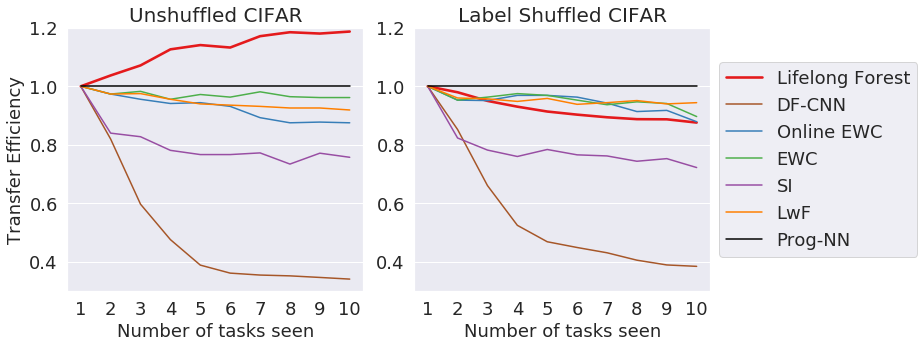

In [45]:
sns.set()
names = ['Lifelong Forest', 'DF-CNN','Online EWC', 'EWC', 'SI', 'LwF', 'Prog-NN']
fig, ax = plt.subplots(1,2, figsize=(13,5))
clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#000000"]
c = sns.color_palette(clr, n_colors=len(names))

for i in range(len(names)):
    if i==0:
        ax[0].plot(np.arange(1,11,1), plt_rte[i], label = names[i], c=c[i], linewidth=2.6)
    else:
        ax[0].plot(np.arange(1,11,1), plt_rte[i], label = names[i], c=c[i])

for i in range(len(names)):
    if i==0:
        ax[1].plot(np.arange(1,11,1), te_[i], c=c[i], label=names[i], linewidth=2.6)
    else:
        ax[1].plot(np.arange(1,11,1), te_[i], c=c[i], label=names[i])

ax[0].set_title('Unshuffled CIFAR', fontsize=20)
ax[0].set_xlabel('Number of tasks seen', fontsize=18)
ax[0].set_ylabel('Transfer Efficiency', fontsize=18)
ax[0].set_yticks([.4,.6,.8,1, 1.2])
ax[0].grid(axis='x')

ax[1].set_title('Label Shuffled CIFAR', fontsize=20)
ax[1].set_xlabel('Number of tasks seen', fontsize=18)
ax[1].set_yticks([.4,.6,.8,1, 1.2])
ax[1].grid(axis='x')
#ax[1].set_ylabel('Transfer Efficiency', fontsize=18)
#fig.legend(loc='upper right', fontsize=12)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
ax[1].set_ylim(0.3, 1.2)
ax[1].set_xticks([1,2,3,4,5,6,7,8,9,10])
ax[1].tick_params(labelsize=18)
ax[0].tick_params(labelsize=18)
ax[0].set_xticks([1,2,3,4,5,6,7,8,9,10])
ax[0].set_ylim(0.3, 1.2)
#ax.grid(axis='x')
plt.tight_layout()
    
plt.savefig('cifar-100-compare.pdf',dpi=500)

In [13]:
import numpy as np

print(np.roll([1,2,3,4],3))
print(np.roll([1,2,3,4],-1))

[2 3 4 1]
[2 3 4 1]
